In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [22]:
# Начальные данные 
r1=0.35
r2=1.2
h=0.14
E=200*10**9
m=0.3
σ=240*10**6

In [23]:
# Вычисление цилиндрической жесткости пластины
D=(E*h**3)/(12*(1-m**2))
print("Цилиндрическая жесткость пластины:", D)

Цилиндрическая жесткость пластины: 50256410.25641027


In [24]:
# Уравнения прогиба 
def w(r, C, D):
    return (C[0] + C[1]*r**2 + C[2]*np.log(r) + C[3]*np.log(r)*r**2)

# Первая производная от угла поворота 
def w1(r, C, D):
    return (C[1]*2*r + (C[2]/r) + C[3]*r + C[3]*2*r*np.log(r))

def w2(r, C, D):
    return (C[1]*2 + (-C[2]/r**2) + C[3]*3 + C[3]*np.log(r)*2) 

def w3(r, C, D):
    return (((C[2]*2)/r**3) + ((C[3]*2)/r))

# Продольная сила 
def w4(r, C, D):
    return (D * (w3(r, C, D) + (1/r)*w2(r, C, D) - (1/r**2)*w1(r, C, D)))

In [25]:
# Моменты 
def Mr_not_mom(r, C, D, m):
    return (D * (w2(r, C, D) + (m/r) * w1(r, C, D)))

def Mr_С(r, C, D, m):
    return ((w2(r, C, D) + (m/r) * w1(r, C, D)) - (1/D))

In [26]:
# Задаем краевые условия 
def equations_to_solve(coefficients, r1, r2, D):
    C = coefficients

    eq1 = w(r1, C, D)
    eq2 = Mr_С(r1, C, D, m)
    eq3 = w4(r2, C, D)
    eq4 = Mr_not_mom(r2, C, D, m)
    
    return [eq1, eq2, eq3, eq4]

In [27]:
# Решение системы. Находим коэффициенты 
initial_guess = [1, 1, 1, 1]
solution = fsolve(equations_to_solve, initial_guess, args=(r1, r2, D))
print("Решение системы:")
print("C1 =", solution[0])
print("C2 =", solution[1])
print("C3 =", solution[2])
print("C4 =", solution[3])

Решение системы:
C1 = -3.908360023844248e-09
C2 = -7.115749525616697e-10
C3 = -3.805909460558415e-09
C4 = 2.176334311579422e-25


In [28]:
C = np.array([solution[0], solution[1], solution[2], solution[3]])
r_values = np.linspace(r1, r2, 100)

# Построение эпюр

def Mr(r, C, D, m):
    return D * (w2(r, C, D) + (m/r) * w1(r, C, D))


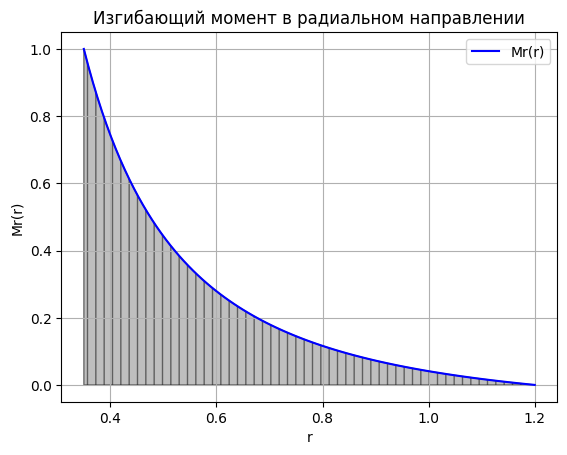

In [29]:
Mr_values = [Mr(r, solution, D, m) for r in r_values]
plt.plot(r_values, Mr_values, color='blue', label='Mr(r)')
plt.fill_between(r_values, Mr_values, color='gray', alpha=0.5, hatch='||', edgecolor='black')
plt.xlabel('r')
plt.ylabel('Mr(r)')
plt.title('Изгибающий момент в радиальном направлении')
plt.grid(True)
plt.legend()
plt.show()

In [30]:
def M0(r, C, D, m):
    return D * (m*w2(r, C, D) + (1/r) * w1(r, C, D))

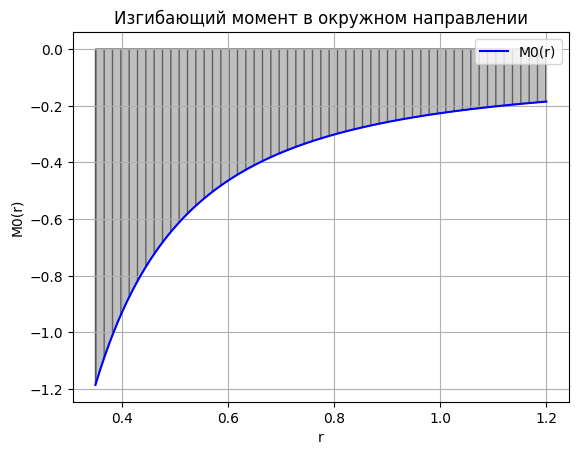

In [31]:
M0_values = [M0(r, solution, D, m) for r in r_values]
plt.plot(r_values, M0_values, color='blue', label='M0(r)')
plt.fill_between(r_values, M0_values, color='gray', alpha=0.5, hatch='||', edgecolor='black')
plt.xlabel('r')
plt.ylabel('M0(r)')
plt.title('Изгибающий момент в окружном направлении')
plt.grid(True)
plt.legend()
plt.show()

In [32]:
# Задаем функции напряжений 
def σ_r(Mr_values, h):
    return 6*np.array(Mr_values)/h**2

def σ_0(M0_values, h):
    return 6*np.array(M0_values)/h**2

def σ_eqv(σ_r,σ_0):
    return np.sqrt(σ_r**2+σ_0**2-σ_r*σ_0)


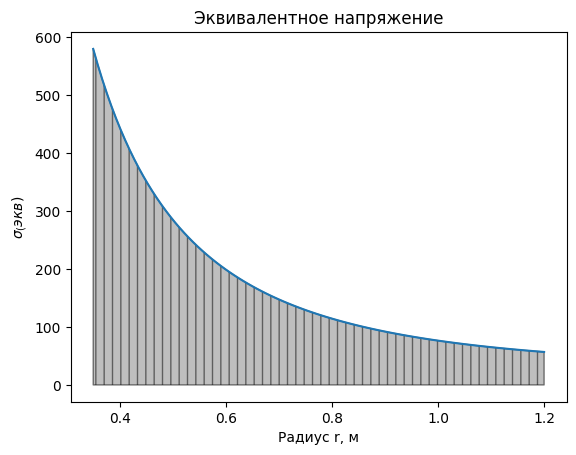

In [33]:
plt.plot(r_values, σ_eqv(σ_r(Mr_values, h), σ_0(M0_values, h)))
plt.fill_between(r_values, σ_eqv(σ_r(Mr_values, h), σ_0(M0_values, h)), color='gray', alpha=0.5, hatch='||', edgecolor='black')
plt.xlabel('Радиус r, м')
plt.ylabel('$σ_(экв)$')
plt.title('Эквивалентное напряжение')
plt.show()

In [34]:
# Вычисление σ_eqv на двух концах
σ_eqv_1=σ_eqv(σ_r(Mr(r1, C, D, m),h),σ_0(M0(r1, C, D, m),h))
σ_eqv_2=σ_eqv(σ_r(Mr(r2, C, D, m),h),σ_0(M0(r2, C, D, m),h))
print("Эквивалентное напряжение при r1:", σ_eqv_1)
print("Эквивалентное напряжение при r2:", σ_eqv_2)

Эквивалентное напряжение при r1: 580.2175509740152
Эквивалентное напряжение при r2: 56.925996204933575


In [35]:
# Находим максимум 
max_σ_eqv=max(σ_eqv_1, σ_eqv_2)
print("Максимальное напряжение:", max_σ_eqv)

Максимальное напряжение: 580.2175509740152


In [36]:
# Допускаемое значение по критерию жесткости 
mom=(σ)/(max_σ_eqv)
print("Допускаемое значение нагрузки:",mom)

Допускаемое значение нагрузки: 413637.9528628707


In [37]:
# Строим эпюру при допускаемом значении 
def w_p(r, C, D, mom):
    return ((C[0] + C[1]*r**2 + C[2]*np.log(r) + C[3]*np.log(r)*r**2)*mom)

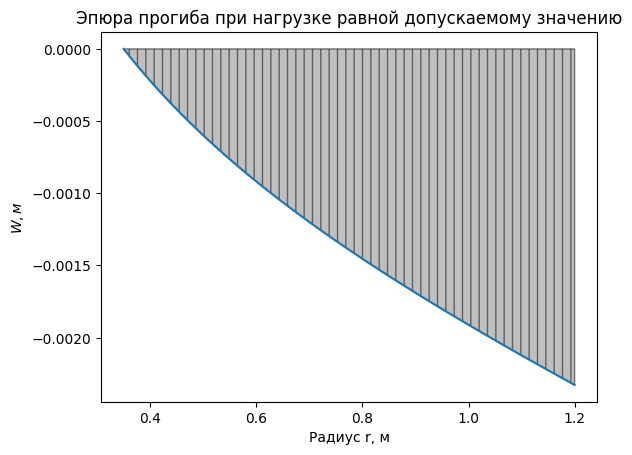

In [38]:
C = np.array([solution[0], solution[1], solution[2], solution[3]])
r_values = np.linspace(r1, r2, 50)
plt.plot(r_values, w_p(r_values, C, D, mom))
plt.fill_between(r_values, w_p(r_values, C, D, mom),color='gray',alpha=0.5, hatch='||',edgecolor='black')
plt.xlabel('Радиус r, м')
plt.ylabel('$W, м$')
plt.title('Эпюра прогиба при нагрузке равной допускаемому значению')
plt.show()

In [39]:
# Строим эпюру для угла поворота при допуск. значении 
def w1_p(r, C, D, mom):
    return ((C[1]*2*r + (C[2]/r) + C[3]*r + C[3]*2*r*np.log(r))*mom)

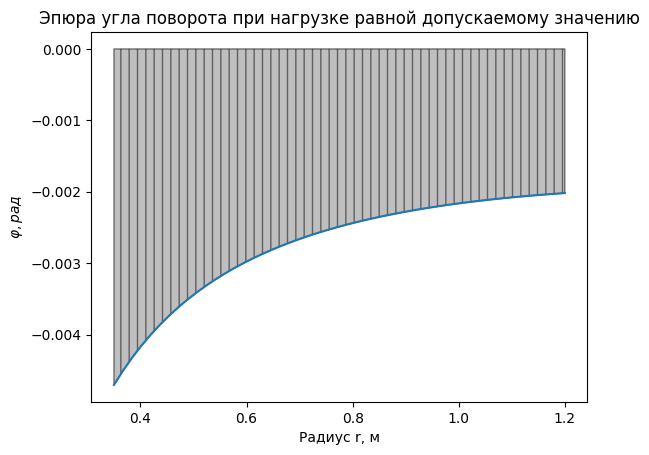

In [40]:
C = np.array([solution[0], solution[1], solution[2], solution[3]])
r_values = np.linspace(r1, r2, 50)
plt.plot(r_values, w1_p(r_values, C, D, mom))
plt.fill_between(r_values, w1_p(r_values, C, D, mom),color='gray',alpha=0.5, hatch='||',edgecolor='black')
plt.xlabel('Радиус r, м')
plt.ylabel('$φ, рад$')
plt.title('Эпюра угла поворота при нагрузке равной допускаемому значению')
plt.show()